# Correct inconsistent default value

Determines a new default value for the input variable `QE01:b1_gradient` (PV name: `QUAD:IN20:425:BACT`), which was inconsistent with is specified range in the original definition of the model.

In [1]:
import torch
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

## Create model

In [2]:
# load transformers
input_sim_to_nn = torch.load("model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load("model/output_sim_to_nn.pt")

In [3]:
# load in- and output variable specification
sim_input_variables, sim_output_variables = variables_from_yaml(open("model/sim_variables.yml"))

In [4]:
# create LUME-model
lume_model = PyTorchModel(
    model_file="model/model.pt",
    input_variables=sim_input_variables,
    output_variables=sim_output_variables,
    input_transformers=[input_sim_to_nn],
    output_transformers=[output_sim_to_nn],
)

In [5]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)
lume_module

LUMEModule(
  (base_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=300, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=True)
    (12): ELU(alpha=1.0)
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=200, bias=True)
    (15): ELU(alpha=1.0)
    (16): Dropout(p=0.05, inplace=False)
    (17): Linear(in_features=200, out_features=100, bias=True)
    (18): ELU(alpha=1.0)
    (19): Dropout(p=0.05, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ELU(alpha=1.0)
    (22): Linear(in_f

## Compute 1D Scan of Model

In [6]:
# variable which needs default correction
var_name = "QE01:b1_gradient"

# old default values
x_default = torch.tensor([sim_input_variables[key].default for key in sim_input_variables.keys()], dtype=torch.double)

In [7]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2) * 1e3

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("sigma_x")
        idx_sigma_y = self.model.output_order.index("sigma_y")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [8]:
# define 1D scan sample function
def scan_x(n_samples, v_lim, name=var_name):
    samples = x_default.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples)
    return samples.double()

In [9]:
# compute 1D scan
n_scan = 1000
idx = list(sim_input_variables.keys()).index(var_name)
v_max = max(sim_input_variables[var_name].value_range)
v_lim = [-v_max, v_max]
x_scan = scan_x(n_scan, v_lim)
with torch.no_grad():
    y_scan = objective_model(x_scan)

# original range
v_lim_old = sim_input_variables[var_name].value_range
x_scan_old = scan_x(n_scan, v_lim_old)
with torch.no_grad():
    y_scan_old = objective_model(x_scan_old)

In [10]:
# new default
idx_min = torch.argmin(x_scan_old[:, idx])
x_default_new = x_scan_old[idx_min, :]
y_default_new = y_scan_old[idx_min]

In [11]:
# load example data
inputs_small = torch.load("info/inputs_small.pt")
outputs_small = torch.load("info/outputs_small.pt")

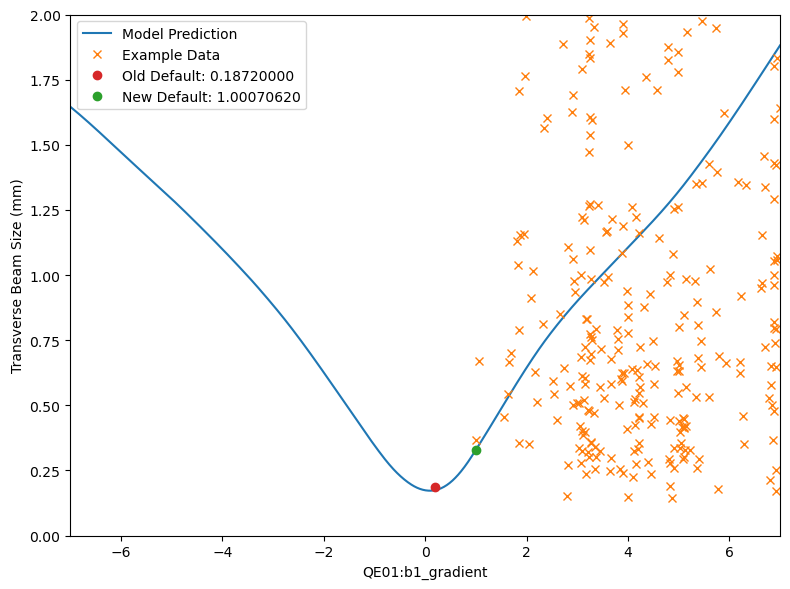

In [12]:
# plot
fig, ax = plt.subplots(figsize=(8, 6))
idx = list(sim_input_variables.keys()).index(var_name)
ax.plot(x_scan[:, idx], y_scan, "C0-", label="Model Prediction")
ax.plot(inputs_small[:, idx], objective_model.function(outputs_small[:, 0], outputs_small[:, 1]), "C1x", label="Example Data")
ax.plot(x_default[idx], sim_input_variables[var_name].default, "C3o", label="Old Default: {:.8f}".format(x_default[idx]))
ax.plot(x_default_new[idx], y_default_new, "C2o", label="New Default: {:.8f}".format(x_default_new[idx]))
ax.set_xlabel(var_name)
ax.set_ylabel("Transverse Beam Size (mm)")
ax.set_xlim(torch.min(x_scan[:, idx]), torch.max(x_scan[:, idx]))
ax.set_ylim(0.0, 2.0)
ax.legend()
fig.tight_layout()

## Transform to PV Variables

In [13]:
# load pv_to_sim transformers
input_pv_to_sim = torch.load('model/input_pv_to_sim.pt')
output_pv_to_sim = torch.load('model/output_pv_to_sim.pt')

In [14]:
# load in- and output variable specification
pv_input_variables, pv_output_variables = variables_from_yaml(open("model/pv_variables.yml"))

In [15]:
# verify old default is matching
x_default_pv = torch.tensor([pv_input_variables[key].default for key in pv_input_variables.keys()], dtype=torch.double)
torch.allclose(x_default_pv, input_pv_to_sim.untransform(x_default))

True

In [16]:
# new default
x_default_pv_new = input_pv_to_sim.untransform(x_default_new)
x_default_pv_new[idx].item()

-1.0807627095349763

In [17]:
# verify new default is in range
v_range = pv_input_variables[list(pv_input_variables.keys())[idx]].value_range
(v_range[0] <= x_default_pv_new[idx] <= v_range[1]).item()

True